In [45]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

In [46]:
def convert_yuv(image):
    rgb_weights_ = [0.2126, 0.5870, 0.1140]
    luma = image[...,:3] @ rgb_weights_
    return luma

In [47]:
def video_to_array():
    path = "dataset/DatasetC.mpg"
    cap = cv2.VideoCapture(path)
    ret = True
    frames = []
    while ret:
        ret, img = cap.read()
        if ret:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            frames.append(convert_yuv(img))
    video_frames = np.stack(frames, axis=0)
    return video_frames

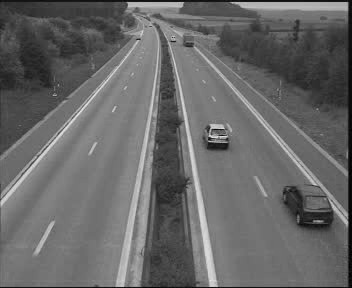

In [48]:
frames_ = video_to_array()
Image.fromarray((frames_[100]).astype(np.uint8))

In [49]:
threshold = 50

In [50]:
def pixel_differencing(frame1, frame2):
    col,row = frame1.shape
    diff_ = np.zeros((col, row))
    for i in range(col):
        for j in range(row):
            frame_diff = np.abs(frame1[i][j] - frame2[i][j])
            
            diff_[i][j] = (frame_diff > threshold)
    
    return diff_

In [51]:
def pixel_differencing_no_thresh(frame1, frame2):
    col,row = frame1.shape
    diff_ = np.zeros((col, row))
    for i in range(col):
        for j in range(row):
            frame_diff = np.abs(frame1[i][j] - frame2[i][j])
            
            diff_[i][j] = (frame_diff)
    
    return diff_

A function that performs pixel-by-pixel frame differencing using, as reference frame, the first
frame of an image sequence. Apply a classification threshold and save the results

In [52]:
col,row = frames_[0].shape
diff_first = np.zeros((len(frames_)-1, col, row))
for i in range(0, 30):
    diff_first[i,:,:] = pixel_differencing_no_thresh(frames_[0], frames_[i+1])

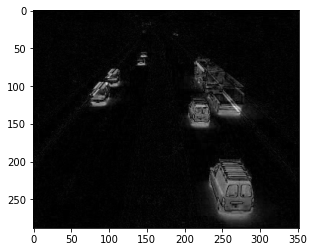

In [53]:
plt.imshow(diff_first[10], cmap="gray")

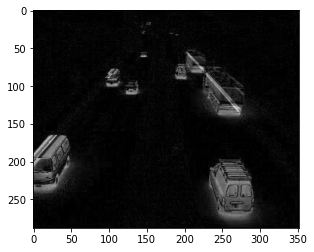

In [54]:
plt.imshow(diff_first[29], cmap="gray")

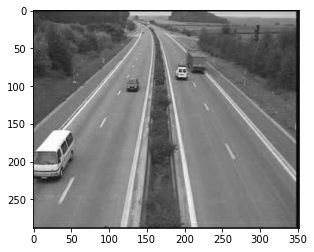

In [55]:
plt.imshow(frames_[29], cmap="gray")

In [56]:
col,row = frames_[0].shape
diff_ = np.zeros((len(frames_)-1, col, row))
for i in range(0, len(frames_) - 1):
    diff_[i,:,:] = pixel_differencing(frames_[0], frames_[i+1])

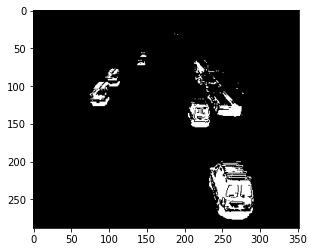

In [57]:
plt.imshow(diff_[10], cmap="gray")

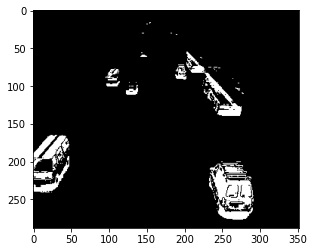

In [58]:
plt.imshow(diff_[29], cmap="gray")

In [59]:
diff_first = np.zeros((len(frames_)-1, col, row))
for i in range(0, 30):
    diff_first[i,:,:] = pixel_differencing_no_thresh(frames_[i], frames_[i+1])

(-0.5, 351.5, 287.5, -0.5)

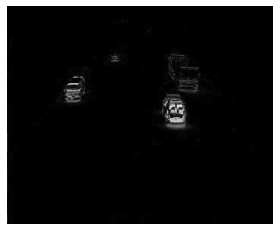

In [60]:
plt.imshow(diff_first[10], cmap="gray")
plt.axis('off')

(-0.5, 351.5, 287.5, -0.5)

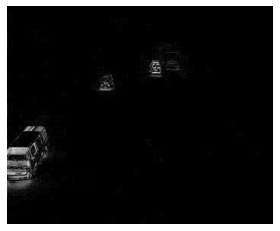

In [61]:
plt.imshow(diff_first[29], cmap="gray")
plt.axis('off')

(-0.5, 351.5, 287.5, -0.5)

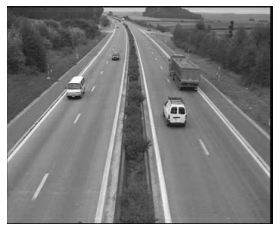

In [62]:
plt.imshow(frames_[10], cmap="gray")
plt.axis('off')

(-0.5, 351.5, 287.5, -0.5)

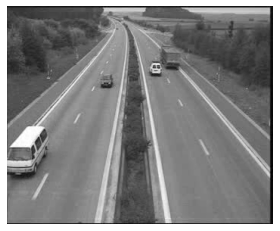

In [63]:
plt.imshow(frames_[29], cmap="gray")
plt.axis('off')

Using the previous frame as reference frame (use frame It-1 as reference frame
for frame It, for each t).

In [64]:
diff_first = np.zeros((len(frames_)-1, col, row))
for i in range(0, len(frames_)-1):
    diff_[i,:,:] = pixel_differencing(frames_[i], frames_[i+1])

(-0.5, 351.5, 287.5, -0.5)

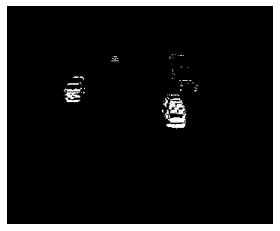

In [65]:
plt.imshow(diff_[10], cmap="gray")
plt.axis('off')

(-0.5, 351.5, 287.5, -0.5)

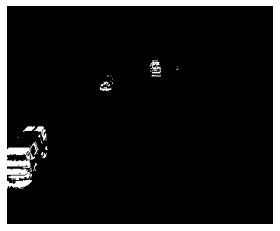

In [66]:
plt.imshow(diff_[29], cmap="gray")
plt.axis('off')

In [67]:
# code for finding the average frame
def average_frame(frames):
    first_frame = frames[0]    
    for i in range(1, len(frames)):
        first_frame = first_frame + frames[i]
    first_frame = first_frame//len(frames)
    return first_frame

A function that generates a reference frame (background) for the sequence using for example
frame differencing and a weighted temporal averaging algorithm. 

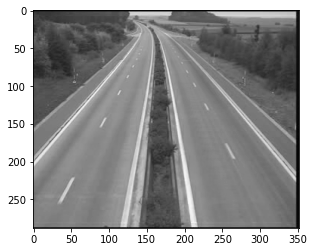

In [68]:
avg_pic = average_frame(frames_)
plt.imshow(avg_pic, cmap="gray")

In [69]:
def dilate(image, dilation_level=7):
    kernel = np.full(shape=(dilation_level, dilation_level), fill_value=1)
    col = kernel.shape[0]
    row = kernel.shape[1]
    conv_image = np.zeros((image.shape[0],image.shape[1]))
    
    for i in range(0+(col//2), image.shape[0]-(col//2)):
        for j in range(0+(row//2), image.shape[1]-(row//2)):
            dilated_part = image[i-(col//2):i+(row//2)+1,j-(col//2):j+(row//2)+1]
            product= dilated_part*kernel
            conv_image[i,j]= np.max(product)
    
    return conv_image

In [70]:
def erode(image, dilation_level=9):
    kernel = np.full(shape=(dilation_level, dilation_level), fill_value=1)
    col = kernel.shape[0]
    row = kernel.shape[1]    
    conv_image = np.zeros((image.shape[0],image.shape[1]))
    
    for i in range(0+(col//2), image.shape[0]-(col//2)):
        for j in range(0+(row//2), image.shape[1]-(row//2)):
            eroded_part = image[i-(col//2):i+(row//2)+1,j-(col//2):j+(row//2)+1]
            product= eroded_part*kernel
            conv_image[i,j]= np.min(product)
    return conv_image

In [71]:
def erode_dialate(pic_):
    pic_ = dilate(pic_)
    pic_ = dilate(pic_)
    pic_ = dilate(pic_)
    pic_ = dilate(pic_)
    pic_ = erode(pic_)
    pic_ = erode(pic_)
    return pic_

In [72]:
pic_ = erode_dialate(diff_[2])

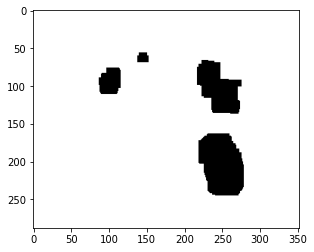

In [73]:
plt.imshow(pic_, cmap="binary")

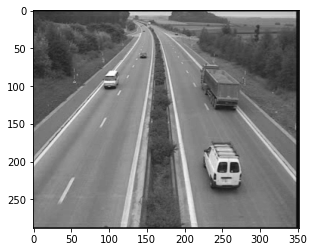

In [74]:
plt.imshow(frames_[2], "gray")

In [75]:
import sys
sys.setrecursionlimit(7000)

In [76]:
class RecursiveConnectedComponentLabeler():
    def find_components(self, label_img, label):
        max_rows, max_cols = label_img.shape
        for i in range(max_rows):
            for j in range(max_cols):
                if label_img[i, j] == -1:
                    label = label + 1
                    self.search(label_img, label, i, j)
        return label

    def search(self, label_img, label, i, j):
        label_img[i, j] = label
        neighborhood = label_img[i - 1:i + 3, j - 1:j + 3]
        for n in range(neighborhood.shape[0]):
            for m in range(neighborhood.shape[1]):
                if neighborhood[n, m] == -1:
                    self.search(label_img, label, i + n - 1, j + m - 1)

    def label_components(self, binary_img):
        label_img = -binary_img
        label = 0
        label = self.find_components(label_img, label)
        return label_img, label

4


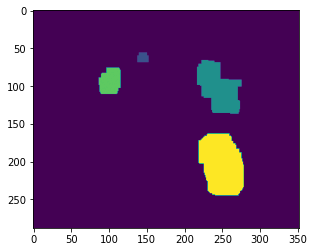

In [77]:
labeler, label = RecursiveConnectedComponentLabeler().label_components(pic_)
plt.imshow(labeler)
print(label)

In [78]:
def pixel_differencing_re_frame(frame1, frame2):
    col,row = frame1.shape
    diff_ = np.zeros((col, row))
    for i in range(col):
        for j in range(row):
            frame_diff = np.abs(frame1[i][j] - frame2[i][j])
            
            diff_[i][j] = (frame_diff > threshold)
    
    return diff_

In [79]:
col,row = frames_[0].shape
diff_ref = np.zeros((len(frames_)-1, col, row))
for i in range(0, len(frames_) - 1):
    diff_ref[i,:,:] = pixel_differencing_re_frame(avg_pic, frames_[i+1])

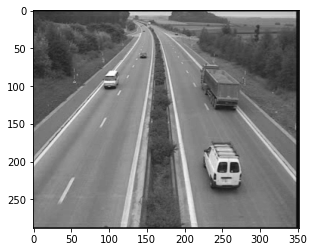

In [80]:
plt.imshow(frames_[2], cmap="gray")

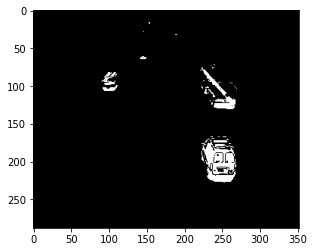

In [81]:
pic_ = erode_dialate(diff_ref[2])
plt.imshow(diff_ref[2], cmap="gray")

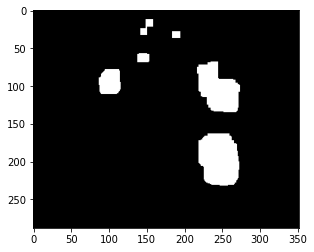

In [82]:
plt.imshow(pic_, cmap="gray")

In [83]:
labeler, label = RecursiveConnectedComponentLabeler().label_components(pic_)
print(label)

6


In [84]:
object_count = [0]*(len(frames_)-1)
for i in range(0, len(frames_)-1):
    pic_ = erode_dialate(diff_ref[i])
    pic_, count = RecursiveConnectedComponentLabeler().label_components(pic_)
    object_count[i] = count

A function that counts the number of moving objects in each frame of a sequence. Generate a
bar plot that visualizes the number of objects for each frame of the whole sequence.

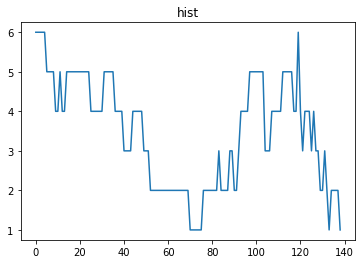

In [85]:
plt.axis('on')
plt.plot(np.arange(len(object_count)), object_count)
plt.title('hist')
plt.show()